# Team 21 MGT 6203 Project Code
### US Inflation Rate Investigation


**Please Note Before Reviewing:**
- This code contains a large amount of coments that would normally be considered unnecessary and over the top in a production code enviroment. This is done purely for the purpose that the reviewer may not be fluent in Python so we wanted to make sure the purpose of each line is documented.

## Library Import

Import necessary files for the analysis.

Additionally, set some standard variables that will be used for visulaization using the Plotly package.

In [ ]:
#dataframes
import pandas as pd
#basic plotting
from matplotlib import pyplot
#lagplots
from pandas.plotting import lag_plot
#displaying outputs with markdown formatting
from IPython.display import display,Markdown
#ploting libraries with interactive features
import plotly
import plotly.graph_objects as go
import plotly.express as px
#effiecient caluations with arrays
import numpy as np
#basic stat functions
import statistics as stats
#option to not show warnings
import warnings
warnings.simplefilter('ignore')
#working with dates
import datetime as dt
#modeling
import statsmodels.formula.api as sm
#statistics library
import scipy.stats as pearsonr
#statistics library
from scipy import stats
#ploting library
import seaborn as sns
#plotting library
import matplotlib.pyplot as plt
#set figure size for seaborn plots
sns.set(rc = {'figure.figsize':(15,8)})


#automated timeseries modeling
'''
import fbprophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.plot import plot_forecast_component
from prophet_plots_plotly import plot_model_components, plot_model
'''

#setting variable for buttons to hide on plotly graphs
buttons_to_remove = ['zoom2d','zoomIn2d','zoomOut2d',
                     'sendDataToCloud',
                     'editInChartStudio',
                     'select2d',
                     'lasso2d',]

#setup variable to reference for plot configuration with plotly
scatter_config = {'displayModeBar': 'Always',
                 "displaylogo": False,
                 'modeBarButtons': 'toggleHover ',
                 'modeBarButtonsToRemove': buttons_to_remove,}

#setup variable for legend configuration with plotly
legend_config = dict(orientation = 'h',
                 yanchor="bottom",
                 y=1.05,
                 xanchor="left",
                 x=0.01)


# Analysis of Historical Inflation Rate

## Import & Modify CPI Data

Import the adjusted overall CPI data (monthly) from the Excel file generated using the US BLS webstite and calculate the annual CPI.

Then create two different dataframes, one to store the yearly CPI data, and one to store the monthly CPI data.

Additionally, calculate the inflation rate for each period based on the CPI for both dataframes.

Lastly, add rolling averages with a window for both CPI and inflation. This will be used for data visualization later.



In [ ]:
'''
Raw CPI Data

Import the raw data for overall CPI & calculate the annual CPI
'''
#import raw overall CPI data
cpi_raw = pd.read_excel('AllItems_CPIRawData.xlsx',engine='openpyxl',sheet_name = 'BLS Data Series',skiprows=11)
display(Markdown('<h2>Raw Overall CPI Data from Excel</h2>'))
display(cpi_raw.head())
#remove 1/2 year averages for CPI
cpi_raw = cpi_raw.loc[:,~cpi_raw.columns.str.startswith('HALF')]

#set year as index value
cpi_raw.set_index('Year',inplace = True)
#calculate the annual CPI based mean of each row
cpi_raw['Annual'] = cpi_raw.mean(numeric_only=True, axis=1)
#reset index so data is no longer the index
cpi_raw.reset_index(inplace = True)
display(Markdown('<h2>Overall CPI Data w/ Calculated Annual CPI</h2>'))
display(cpi_raw.head())

'''
Yearly CPI Data

Use annual calcualtion to create a dataframe of yearly CPI data. 
Then calculate inflation rate as well as the rolling average/window caluations.
'''
#copy the raw dataframe to avoid accidental inplace operations
cpi_yearly = cpi_raw.copy()
#remove monthly columns by only keeping the year & annual columns
cpi_yearly = cpi_yearly[['Year','Annual']]
#change the column names to make referencing between the yearly and monthly data easier
cpi_yearly.rename(columns={"Annual": "CPI",'Year': 'Date'},inplace=True)

#set rolling avg window for yearly data
window_yearly = 3

#Calulate rolling avg for CPI based on time window using series.rolling()
cpi_yearly['RollingAvgCPI'] = cpi_yearly.CPI.rolling(window_yearly).mean()
#calculate the roling average window as the min & max of the window
cpi_yearly['RollingAvgCPI_low'] = cpi_yearly.CPI.rolling(window_yearly).min()
cpi_yearly['RollingAvgCPI_high'] = cpi_yearly.CPI.rolling(window_yearly).max()

#calculate inflation rate based on % difference of subsequent CPI values
cpi_yearly['Inflation'] = (cpi_yearly.CPI.diff()/ cpi_yearly['CPI'].shift(1))*100
#Calulate rolling avg for inflation based on time window using series.rolling()
cpi_yearly['RollingAvgInflation'] = cpi_yearly.Inflation.rolling(window_yearly).mean()
#calculate the roling average window as the min & max of the window
cpi_yearly['RollingAvgInflation_low'] = cpi_yearly.Inflation.rolling(window_yearly).min()
cpi_yearly['RollingAvgInflation_high'] = cpi_yearly.Inflation.rolling(window_yearly).max()

display(Markdown('<h2>Yearly CPI and Inflation Data</h2>'))
display(cpi_yearly.head())


'''
Transform CPI data into monthly format and calculate inflation
'''
#copy the raw dataframe to avoid accidental inplace operations
cpi_monthly =  cpi_raw.copy()
#drop annual column since it's not needed for the monthly data
cpi_monthly.drop(columns = ['Annual'], inplace = True)

window_monthly = 6

#use pd.melt to combine columns and rows to get a year and month column
cpi_monthly = pd.melt(cpi_monthly, id_vars=["Year"], var_name="Month", value_name = "CPI")
#next few lines modify columns to get usable format and calculate inflation
#combine month and year columns into Date column using string comprehension
cpi_monthly['Date'] = cpi_monthly.Month + " " + cpi_monthly.Year.map(str)
#remove month and year columns by only keeping date and CPI
cpi_monthly = cpi_monthly[['Date','CPI']]
#convert Date column from string to datetime using pd.to_datetime
cpi_monthly["Date"] = pd.to_datetime(cpi_monthly.Date, format="%b %Y", dayfirst=True)
#sort values from earliest to latest date
cpi_monthly = cpi_monthly.sort_values("Date")
#reformat Date column as date instead of datetime for display purposes
cpi_monthly ['Date'] = cpi_monthly['Date'].dt.date

#calculate month to month inflation rate
cpi_monthly['Inflation'] = (cpi_monthly.CPI.diff()/ cpi_monthly['CPI'].shift(1))*100

#Calulate rolling avg for CPI based on time window using series.rolling()
cpi_monthly['RollingAvgCPI'] = cpi_monthly.CPI.rolling(window_monthly).mean()
#calculate the roling average window as the min & max of the window
cpi_monthly['RollingAvgCPI_low'] = cpi_monthly.CPI.rolling(window_monthly).min()
cpi_monthly['RollingAvgCPI_high'] = cpi_monthly.CPI.rolling(window_monthly).max()

#calculate inflation rate based on % difference of subsequent CPI values
cpi_monthly['Inflation'] = (cpi_monthly.CPI.diff()/ cpi_monthly['CPI'].shift(1))*100
#Calulate rolling avg for inflation based on time window using series.rolling()
cpi_monthly['RollingAvgInflation'] = cpi_monthly.Inflation.rolling(window_monthly).mean()
#calculate the roling average window as the min & max of the window
cpi_monthly['RollingAvgInflation_low'] = cpi_monthly.Inflation.rolling(window_monthly).min()
cpi_monthly['RollingAvgInflation_high'] = cpi_monthly.Inflation.rolling(window_monthly).max()

display(Markdown('<h2>Monthly CPI and Inflation Data</h2>'))
display(cpi_monthly.head())
#blank print statement at the end otherwise, deepnote formats last DF displayed differently
print()

<h2>Raw Overall CPI Data from Excel</h2>

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,HALF1,HALF2
0,1947,21.48,21.62,22.00,22.00,21.95,22.08,22.23,22.40,22.84,22.91,23.06,23.41,NaN,NaN
1,1948,23.68,23.67,23.50,23.82,24.01,24.15,24.40,24.43,24.36,24.31,24.16,24.05,NaN,NaN
2,1949,24.01,23.91,23.91,23.92,23.91,23.92,23.70,23.70,23.75,23.67,23.70,23.61,NaN,NaN
3,1950,23.51,23.61,23.64,23.65,23.77,23.88,24.07,24.20,24.34,24.50,24.60,24.98,NaN,NaN
4,1951,25.38,25.83,25.88,25.92,25.99,25.93,25.91,25.86,26.03,26.16,26.32,26.47,NaN,NaN


<h2>Overall CPI Data w/ Calculated Annual CPI</h2>

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual
0,1947,21.48,21.62,22.00,22.00,21.95,22.08,22.23,22.40,22.84,22.91,23.06,23.41,22.331667
1,1948,23.68,23.67,23.50,23.82,24.01,24.15,24.40,24.43,24.36,24.31,24.16,24.05,24.045000
2,1949,24.01,23.91,23.91,23.92,23.91,23.92,23.70,23.70,23.75,23.67,23.70,23.61,23.809167
3,1950,23.51,23.61,23.64,23.65,23.77,23.88,24.07,24.20,24.34,24.50,24.60,24.98,24.062500
4,1951,25.38,25.83,25.88,25.92,25.99,25.93,25.91,25.86,26.03,26.16,26.32,26.47,25.973333


<h2>Yearly CPI and Inflation Data</h2>

,Date,CPI,RollingAvgCPI,RollingAvgCPI_low,RollingAvgCPI_high,Inflation,RollingAvgInflation,RollingAvgInflation_low,RollingAvgInflation_high
0,1947,22.331667,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1948,24.045000,NaN,NaN,NaN,7.672214,NaN,NaN,NaN
2,1949,23.809167,23.395278,22.331667,24.045000,-0.980800,NaN,NaN,NaN
3,1950,24.062500,23.972222,23.809167,24.062500,1.064016,2.585143,-0.9808,7.672214
4,1951,25.973333,24.615000,23.809167,25.973333,7.941126,2.674781,-0.9808,7.941126


<h2>Monthly CPI and Inflation Data</h2>

,Date,CPI,Inflation,RollingAvgCPI,RollingAvgCPI_low,RollingAvgCPI_high,RollingAvgInflation,RollingAvgInflation_low,RollingAvgInflation_high
0,1947-01-01,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
76,1947-02-01,21.62,0.651769,NaN,NaN,NaN,NaN,NaN,NaN
152,1947-03-01,22.00,1.757632,NaN,NaN,NaN,NaN,NaN,NaN
228,1947-04-01,22.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
304,1947-05-01,21.95,-0.227273,NaN,NaN,NaN,NaN,NaN,NaN


## Plot CPI and Inflation Data with Rolling Avg

Plot the yearly and monthly CPI/Inflation data over time with the rolling avgerages/windows to see how CPI and Inflation behaved over time for both data sets.

In [ ]:
'''
CPI Yearly

Plot annual CPI over time with rolling avg/window
'''

#create blank plotly.graph_objects.go.Figure object
fig = go.Figure()

#set up each a variable for each item to be graphed
#x-axis will be Date for every y variable
y = cpi_yearly['CPI']
x = cpi_yearly['Date']
y_roll = cpi_yearly['RollingAvgCPI']
y_rollmin = cpi_yearly['RollingAvgCPI_low']
y_rollmax = cpi_yearly['RollingAvgCPI_high']

#Add a trace for the annual CPI
fig.add_trace(go.Scatter(x=x, y=y,
                         marker=dict(color='#005100',size = 5),
                         line = dict(color='#005100',width = 1),
                         mode='markers+lines',
                         name='Yearly CPI'))

#Add a trace for the rolling avg CPI
fig.add_trace(go.Scatter(x=x, y=y_roll,
                         line = dict(color='#FF3333',width = 1),
                         mode='lines',
                         name=f'{window_yearly} Year Rolling Avg'))

#Add a trace for the min value of rolling CPI
fig.add_trace(go.Scatter(x=x, y=y_rollmin,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         name=f'{window_yearly} Year Rolling Low'))

#Add a trace for the max value of rolling CPI
fig.add_trace(go.Scatter(x=x, y=y_rollmax,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         fill='tonexty',
                         name=f'{window_yearly} Year Rolling High'))

#update x-axis display properties
fig.update_xaxes(tickangle=-45, tickfont = dict(family = 'Arial', size = 14,color = 'black'))
#update figure layout to display all data on over (x-unified) and set figure size
fig.update_layout(hovermode="x unified",clickmode ='select',height=500,width=1100,)
#update legend config
fig.update_layout(legend=legend_config)

display(Markdown('<h2>Yearly CPI Data</h2>'))
fig.show(config=scatter_config)

'''
CPI Monthly

Plot monthly CPI over time with rolling avg/window
'''

#create blank plotly.graph_objects.go.Figure object
fig = go.Figure()

#set up each a variable for each item to be graphed
#x-axis will be Date for every y variable
y = cpi_monthly['CPI']
x = cpi_monthly['Date']
y_roll = cpi_monthly['RollingAvgCPI']
y_rollmin = cpi_monthly['RollingAvgCPI_low']
y_rollmax = cpi_monthly['RollingAvgCPI_high']

#Add a trace for the monthly CPI
fig.add_trace(go.Scatter(x=x, y=y,
                         marker=dict(color='#005100',size = 5),
                         line = dict(color='#005100',width = 1),
                         mode='markers+lines',
                         name='Monthly CPI'))

#Add a trace for the rolling avg CPI
fig.add_trace(go.Scatter(x=x, y=y_roll,
                         line = dict(color='#FF3333',width = 1),
                         mode='lines',
                         name=f'{window_monthly} Month Rolling Avg'))

#Add a trace for the min value of rolling CPI
fig.add_trace(go.Scatter(x=x, y=y_rollmin,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         name=f'{window_monthly} Month Rolling Low'))

#Add a trace for the max value of rolling CPI
fig.add_trace(go.Scatter(x=x, y=y_rollmax,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         fill='tonexty',
                         name=f'{window_monthly} Month Rolling High'))

#update x-axis display properties
fig.update_xaxes(tickangle=-45, tickfont = dict(family = 'Arial', size = 14,color = 'black'))
#update figure layout to display all data on over (x-unified) and set figure size
fig.update_layout(hovermode="x unified",clickmode ='select',height=500,width=1100,)
#update legend config
fig.update_layout(legend=legend_config)

display(Markdown('<h2>Monthly CPI Data</h2>'))
fig.show(config=scatter_config)

'''
Inflation Yearly

Plot annual inflation rate over time with rolling avg/window
'''

#create blank plotly.graph_objects.go.Figure object
fig = go.Figure()

#set up each a variable for each item to be graphed
#x-axis will be Date for every y variable
y = cpi_yearly['Inflation']
x = cpi_yearly['Date']
y_roll = cpi_yearly['RollingAvgInflation']
y_rollmin = cpi_yearly['RollingAvgInflation_low']
y_rollmax = cpi_yearly['RollingAvgInflation_high']

#Add a trace for the annual inflation
fig.add_trace(go.Scatter(x=x, y=y,
                         marker=dict(color='#005100',size = 5),
                         line = dict(color='#005100',width = 1),
                         mode='markers+lines',
                         name='Yearly Inflation'))

#Add a trace for the rolling avg inflation
fig.add_trace(go.Scatter(x=x, y=y_roll,
                         line = dict(color='#FF3333',width = 1),
                         mode='lines',
                         name=f'{window_yearly} Year Rolling Avg'))

#Add a trace for the min value of rolling inflation
fig.add_trace(go.Scatter(x=x, y=y_rollmin,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         name=f'{window_yearly} Year Rolling Low'))

#Add a trace for the max value of rolling inflation
fig.add_trace(go.Scatter(x=x, y=y_rollmax,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         fill='tonexty',
                         name=f'{window_yearly} Year Rolling High'))

#update x-axis display properties
fig.update_xaxes(tickangle=-45, tickfont = dict(family = 'Arial', size = 14,color = 'black'))
#update figure layout to display all data on over (x-unified) and set figure size
fig.update_layout(hovermode="x unified",clickmode ='select',height=500,width=1100,)
#update legend config
fig.update_layout(legend=legend_config)

display(Markdown('<h2>Yearly Inflation Data</h2>'))
fig.show(config=scatter_config)


'''
Inflation Monthly

Plot monthly inflation rate over time with rolling avg/window
'''

#create blank plotly.graph_objects.go.Figure object
fig = go.Figure()

#set up each a variable for each item to be graphed
#x-axis will be Date for every y variable
y = cpi_monthly['Inflation']
x = cpi_monthly['Date']
y_roll = cpi_monthly['RollingAvgInflation']
y_rollmin = cpi_monthly['RollingAvgInflation_low']
y_rollmax = cpi_monthly['RollingAvgInflation_high']

#Add a trace for the monthly inflation
fig.add_trace(go.Scatter(x=x, y=y,
                         marker=dict(color='#005100',size = 5),
                         line = dict(color='#005100',width = 1),
                         mode='markers+lines',
                         name='Monthly Inflation'))

#Add a trace for the rolling avg inflation
fig.add_trace(go.Scatter(x=x, y=y_roll,
                         line = dict(color='#FF3333',width = 1),
                         mode='lines',
                         name=f'{window_monthly} Month Rolling Avg'))

#Add a trace for the min value of rolling inflation
fig.add_trace(go.Scatter(x=x, y=y_rollmin,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         name=f'{window_monthly} Month Rolling Low'))

#Add a trace for the max value of rolling inflation
fig.add_trace(go.Scatter(x=x, y=y_rollmax,
                         line = dict(color='#bf9fa2',width = 1),
                         mode='lines',
                         fill='tonexty',
                         name=f'{window_monthly} Month Rolling High'))


#update x-axis display properties
fig.update_xaxes(tickangle=-45, tickfont = dict(family = 'Arial', size = 14,color = 'black'))
#update figure layout to display all data on over (x-unified) and set figure size
fig.update_layout(hovermode="x unified",clickmode ='select',height=500,width=1100,)
#update legend config
fig.update_layout(legend=legend_config)

display(Markdown('<h2>Monthly Inflation Data</h2>'))
fig.show(config=scatter_config)

<h2>Yearly CPI Data</h2>

<h2>Monthly CPI Data</h2>

<h2>Yearly Inflation Data</h2>

<h2>Monthly Inflation Data</h2>

# Driving Factors of Inflation Rate Analysis

## Categorical Pricing Data

Import the seasonally adjusted categorical CPI data (monthly) from the Excel file generated using the US BLS webstite and reformat into usable format.

Import the series keys data that map the SeriesID to the name of the category. Note that we also needed to filter out some series IDs because the data from the US BLS included sub-categories along with the main categories.

Remap the SeriesID column names to category names using the series keys data.


In [ ]:
'''
Categorical CPI Data Import
'''
#load in data for adjusted categorical CPI data 
cat_pricing = pd.read_excel('CategoryPriceData_BLS.xlsx',engine='openpyxl',sheet_name = 'BLS Data Series',skiprows=3)
display(Markdown('<h2>Raw Categorial CPI Data from Excel</h2>'))
display(cat_pricing.head())

'''
Reformat categorical data
'''
#remove all the 1/2 year calculations that were in the data set
cat_pricing = cat_pricing.loc[:,~cat_pricing.columns.str.startswith('HALF')]
#set the series ID as the index so when we transpose, it becomes the column name
cat_pricing.set_index('Series ID',inplace = True)
#transpose the data so series IDs become column names and Dates become rows
cat_pricing = cat_pricing.T
#reset index to make it easier to reference/modify date column
cat_pricing.reset_index(inplace = True)
#rename date column from index (default name for unnamed index) to Date
cat_pricing.rename(columns = {'index': 'Date'},inplace = True)
#replace next line indicator (\n_ in the date column with a space
cat_pricing.replace({'\n': ' '}, regex=True,inplace =True)
#convert date column to datetime with pd.to_datetime
cat_pricing["Date"] = pd.to_datetime(cat_pricing.Date, format="%b %Y", dayfirst=True)
#set date as the index
cat_pricing.set_index('Date',inplace = True)
display(Markdown('<h2>Reformatted Categorical CPI Data</h2>'))
display(cat_pricing.head())

'''
Import data that maps series IDs to the categorical name
'''
#import series ID mapping data
series_keys = pd.read_excel('CategoryPriceData_BLS.xlsx',engine='openpyxl',sheet_name = 'ItemCodes')
#keep only necessary columnd for the SeriesID (FullCode) and category name (item_name)
series_keys = series_keys[['FullCode','item_name']]
#Remove any SeriesIDs that are not in the category data
series_keys = series_keys[series_keys['FullCode'].isin(cat_pricing.columns)]
#rename some of the names from the US BLS to be cleaner
series_keys.replace('Energy  1','Energy',inplace = True)
series_keys.replace('Apparel 0','Apparel',inplace = True)
series_keys.replace('Housing 0','Housing',inplace = True)
series_keys.replace('Transportation  0','Transportation',inplace = True)
display(Markdown('<h2>Categorical Name Mapping</h2>'))
display(series_keys.head())

#iterate over each column in cat_pricing and replace the SeriesID with the category name
for column in cat_pricing.columns:
    #set a temp variable for the category name associated with a seriesID
    temp_real_col = series_keys['item_name'][series_keys['FullCode'] == column].values[0]
    #this line was just to check the loop was performing as expected
    #print(temp_real_col)
    #rename series ID column name to the category name
    cat_pricing.rename(columns = {column: temp_real_col},inplace = True)

display(Markdown('<h2>Categorical CPI Data After Remapping</h2>'))
display(cat_pricing.head())
#blank print statement at the end otherwise, deepnote formats last DF displayed differently
print()

<h2>Raw Categorial CPI Data from Excel</h2>

,Series ID,Jan\n1947,Feb\n1947,Mar\n1947,Apr\n1947,May\n1947,Jun\n1947,Jul\n1947,Aug\n1947,Sep\n1947,...,May\n2022,Jun\n2022,Jul\n2022,Aug\n2022,Sep\n2022,Oct\n2022,Nov\n2022,Dec\n2022,HALF1\n2022,HALF2\n2022
0,CUSR0000SA0E,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CUSR0000SAA,38.4,38.8,39.4,39.7,39.8,40.0,40.0,40.1,40.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CUSR0000SAE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CUSR0000SAF1,22.8,23.1,23.8,23.5,23.4,23.5,23.8,24.1,24.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,CUSR0000SAG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Reformatted Categorical CPI Data</h2>

Series ID,CUSR0000SA0E,CUSR0000SAA,CUSR0000SAE,CUSR0000SAF1,CUSR0000SAG,CUSR0000SAH,CUSR0000SAH3,CUSR0000SAM,CUSR0000SAR,CUSR0000SAT
Date,,,,,,,,,,
1947-01-01,NaN,38.4,NaN,22.8,NaN,NaN,NaN,13.2,NaN,17.9
1947-02-01,NaN,38.8,NaN,23.1,NaN,NaN,NaN,13.3,NaN,17.9
1947-03-01,NaN,39.4,NaN,23.8,NaN,NaN,NaN,13.3,NaN,18.1
1947-04-01,NaN,39.7,NaN,23.5,NaN,NaN,NaN,13.4,NaN,18.3
1947-05-01,NaN,39.8,NaN,23.4,NaN,NaN,NaN,13.5,NaN,18.3


<h2>Categorical Name Mapping</h2>

,FullCode,item_name
3,CUSR0000SA0E,Energy
14,CUSR0000SAA,Apparel
24,CUSR0000SAE,Education and communication
31,CUSR0000SAF1,Food
42,CUSR0000SAG,Other goods and services


<h2>Categorical CPI Data After Remapping</h2>

Series ID,Energy,Apparel,Education and communication,Food,Other goods and services,Housing,Household furnishings and operations,Medical care,Recreation,Transportation
Date,,,,,,,,,,
1947-01-01,NaN,38.4,NaN,22.8,NaN,NaN,NaN,13.2,NaN,17.9
1947-02-01,NaN,38.8,NaN,23.1,NaN,NaN,NaN,13.3,NaN,17.9
1947-03-01,NaN,39.4,NaN,23.8,NaN,NaN,NaN,13.3,NaN,18.1
1947-04-01,NaN,39.7,NaN,23.5,NaN,NaN,NaN,13.4,NaN,18.3
1947-05-01,NaN,39.8,NaN,23.4,NaN,NaN,NaN,13.5,NaN,18.3


## Plot Categorical CPI Data Over Time with Overall CPI

Filter data for overall CPI for only dates where we have categorical data then add the overall CPI to the categorical dataframe.

Plot the data for each category and the overall CPI.

In [ ]:
#copy the categorical data to a new dataframe to avoid accidental inplace operations
vis_cat_pricing = cat_pricing.copy()

#copy the monthly CPI data to a new dataframe to avoid accidental inplace operations
cpi_monthly_vis = cpi_monthly.copy()
#format monthly data as datetime to allow us to filter dates easily
cpi_monthly_vis["Date"] = pd.to_datetime(cpi_monthly_vis.Date, dayfirst=True)
#set index as the date so we can use .loc for filtering
cpi_monthly_vis.set_index('Date',inplace = True)
#filter overall CPI data for only times when we have data for categories
cpi_monthly_vis = cpi_monthly_vis.loc['1947-01-01':'2022-02-01']

#create column in vis_cat_pricing for overall CPI
vis_cat_pricing['Overall CPI'] = cpi_monthly_vis['CPI']

#create blank plotly.graph_objects.go.Figure object
fig = go.Figure()
#set x values as the date
x = vis_cat_pricing.index.values

#set a color sequence for better visualization
color_sequence = ['#e6194b', 
                  '#3cb44b', 
                  '#ffe119', 
                  '#4363d8', 
                  '#f58231', 
                  '#911eb4', 
                  '#46f0f0', 
                  '#f032e6', 
                  '#bcf60c', 
                  '#fabebe', 
                  '#000000',]
#initialize counter for color sequence
count = 0
#iterate over each column in vis_cat_pricing
for column in vis_cat_pricing.columns:
    #set condition specifically for overall CPI column so we can manually set color
    #both conditions just set the y values as the current column
    #then it adds a trace to the figure
    y_temp = vis_cat_pricing[column].values
    fig.add_trace(go.Scatter(x=x, y=y_temp,
                    mode='lines',
                    name=column,
                    marker_color = color_sequence[count]))

    count += 1

#update x-axis display properties
fig.update_xaxes(tickangle=-45, tickfont = dict(family = 'Arial', size = 14,color = 'black'))
#update figure layout to display all data on over (x-unified) and set figure size
fig.update_layout(hovermode="x unified",clickmode ='select',height=500,width=1100,)

display(Markdown('<h2>Categorical CPI Data Plot</h2>'))
fig.show()

<h2>Categorical CPI Data Plot</h2>

## Driving Factors Modeling

Add the CPI column cat_pricing and then filter rows from 1993 onwards as we have data for all the categories from 1993 onwards since that is the period where we start having data for all the variables.

Scale the data and create a correlation matrix to check for co-linearity.

Create a linear regression model.


<h3>CPI Data for Modeling (scaled) Jan-1993 to Feb-2022</h3>

Series ID,Energy,Apparel,EducationAndCommunication,Food,OtherGoodsAndServices,Housing,HouseholdFurnishingsAndOperations,MedicalCare,Recreation,Transportation,CPI
Date,,,,,,,,,,,
1993-01-01,0.032960,0.888948,0.000000,0.000000,0.000000,0.000000,0.004629,0.000000,0.000000,0.000000,0.000000
1993-02-01,0.028982,0.946888,0.003343,0.003251,0.002617,0.000000,0.004629,0.002947,0.007639,0.003154,0.002122
1993-03-01,0.032392,0.946888,0.008359,0.003251,0.006214,0.002632,0.000000,0.005010,0.017824,0.001577,0.003537
1993-04-01,0.032392,0.946888,0.011702,0.005851,0.008504,0.006581,0.027771,0.007957,0.025463,0.003154,0.007073
1993-05-01,0.028982,0.922746,0.018389,0.012353,0.011775,0.007897,0.023143,0.012083,0.015278,0.005519,0.009902
...,...,...,...,...,...,...,...,...,...,...,...
2021-10-01,0.885435,0.360243,0.995185,0.941487,0.959270,0.959881,0.752928,0.977609,0.957578,0.888022,0.946302
2021-11-01,0.920935,0.404181,0.995670,0.955387,0.962838,0.969069,0.805739,0.982383,0.951339,0.926838,0.959981
2021-12-01,0.933983,0.469702,0.997141,0.964424,0.970845,0.978348,0.874844,0.986845,0.947571,0.953299,0.971312


<h3>Correlation Matrix</h3>

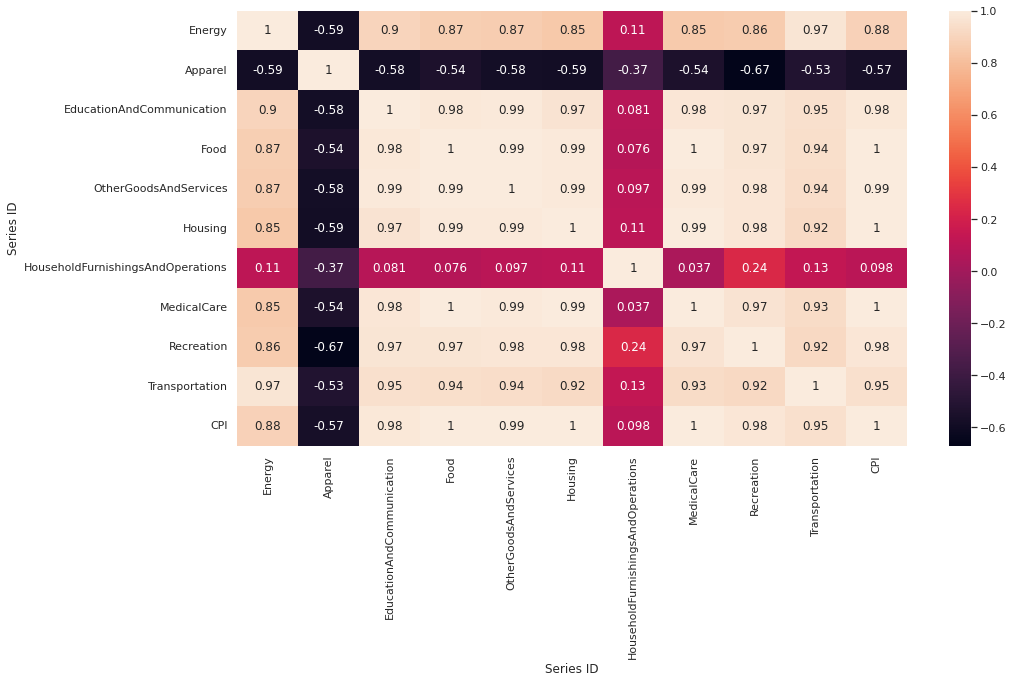

<h3>Modeling Results Summary</h3>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    CPI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.270e+06
Date:                Tue, 26 Apr 2022   Prob (F-statistic):               0.00
Time:                        13:41:06   Log-Likelihood:                 1772.7
No. Observations:                 350   AIC:                            -3527.
Df Residuals:                     341   BIC:                            -3493.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                            -0.0053      0.001     -6.040      0.000      -0.007      -0.004
Apparel                               0.0042      0.001      5.379      0.000       0.003       0.006
EducationAndCommunication             0.0922      0.004     23.229      0.000       0.084       0.100
Energy                               -0.0243      0.002    -12.057      0.000      -0.028      -0.020
Food                                  0.1643      0.007     23.909      0.000       0.151       0.178
HouseholdFurnishingsAndOperations    -0.0142      0.001    -12.207      0.000      -0.016      -0.012
Housing                               0.5477      0.006     93.777      0.000       0.536       0.559
Recreation                            0.0310      0.005      6.247      0.000       0.021       0.041
Transportation                        0.2058      0.003     59.518      0.000       0.199       0.213
==============================================================================
Omnibus:                        5.461   Durbin-Watson:                   0.141
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                3.542
Skew:                           0.041   Prob(JB):                        0.170
Kurtosis:                       2.514   Cond. No.                         212.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<h3>Sorted Model Coefficients</h3>

,RegressionCoef
Housing,0.547749
Transportation,0.205767
Food,0.164291
EducationAndCommunication,0.092192
Recreation,0.030964
Energy,-0.024268
HouseholdFurnishingsAndOperations,-0.014186
Apparel,0.004214


In [ ]:
'''
Add Overall CPI to the Category Data
'''
#copy the categorical data to a new dataframe to avoid accidental inplace operations
cat_pricing_1993 = cat_pricing.copy()
#copy the monthly overall CPI data to a new dataframe to avoid accidental inplace operations
cpi_monthly_1993 = cpi_monthly.copy()

cpi_monthly_1993["Date"] = pd.to_datetime(cpi_monthly_1993.Date, dayfirst=True)
cpi_monthly_1993.set_index('Date',inplace = True)
cat_pricing_1993['CPI'] = cpi_monthly_1993['CPI']
cat_pricing_1993 = cat_pricing_1993.loc['1993-01-01':'2022-02-01']

'''
Scale Data
'''
#scale the data using (x-xmin)/(xmax-xmin)
scaled_data=(cat_pricing_1993-cat_pricing_1993.min())/(cat_pricing_1993.max()-cat_pricing_1993.min())
#this line is legacy code from when we were testing scaling vs. standardization
#scaled_data=(cat_pricing_1993-cat_pricing_1993.min())/(cat_pricing_1993.std())

#replace spaces in column names and make them camel case
#this is needed for the model to accept column inputs
scaled_data.columns = scaled_data.columns.str.title().str.replace(' ', '')
#change CPI back to all caps
scaled_data.rename(columns= {'Cpi': 'CPI'},inplace = True)

display(Markdown('<h3>CPI Data for Modeling (scaled) Jan-1993 to Feb-2022</h3>'))
display(scaled_data)

'''
Generate Corr Matrix to Check Colinearity
'''
#create a correlation matrix
cormat = scaled_data.corr()
#generate heatmap from corr matrix
sns.heatmap(cormat, annot=True)
display(Markdown('<h3>Correlation Matrix</h3>'))
plt.show()

'''
Create Regression Model
'''
#set name of response variable
response  = 'CPI'
#set variables to exclude based on corrmatrix
exclude =['OtherGoodsAndServices', 'MedicalCare']
#set a string that is all the variables that will be used for prediction
predictors = ' + '.join(scaled_data.columns.difference([response]+exclude))
#set a value for the string formula used for the model
formula = response + ' ~ ' + predictors

#fit linear model based on previous formula and scaled data
model = sm.ols(formula=formula, data=scaled_data).fit()
display(Markdown('<h3>Modeling Results Summary</h3>'))
display(model.summary())

#create a dataframe to store regression coefficients
coefs = pd.DataFrame(model.params,columns=['RegressionCoef'])
#exclude the intercept
coefs = coefs[~coefs.index.isin(['Intercept'])]
display(Markdown('<h3>Sorted Model Coefficients</h3>'))
#stort regression coefs from largest to smalled by abs value
display(coefs.sort_values(by='RegressionCoef', key=abs, ascending=False))
print()

# Analysis of Items Rising Above/Below/At Inflation

## Import Unadjusted Data for Overall CPI and Item CPI

Import the data for both seasonally unadjusted overall CPI and individual item CPI. Also import the SeriesID mappings for the individual items. 

Reformat both data structures to suit the needs of the analysis.

We do not rename the Series IDs here and keep them inplace. This is because the item names are very long and would not be good for visualization. We can simply use the name mapping to do this at the end.

**NOTE:** We had to use unadjusted data for this since there is no data available for seasonally adjusted item data

In [ ]:
'''
Unadjusted Overall CPI Data

Import and reformat data
'''
#import cpi data
cpi_unadj = pd.read_excel('CPIRawData_unadj.xlsx',engine='openpyxl',sheet_name = 'BLS Data Series',skiprows=11)

display(Markdown('<h2>Raw Unadjusted CPI Data from Excel</h2>'))
display(cpi_unadj.head())

#remove 1/2 year and annual columns for CPI since we only need monthly data
cpi_unadj = cpi_unadj.loc[:,~cpi_unadj.columns.str.startswith('HALF')]
cpi_unadj.drop(columns = ['Annual'], inplace = True)

#use pd.melt to combine columns and rows to get a year and month column
cpi_unadj = pd.melt(cpi_unadj, id_vars=["Year"], var_name="Month", value_name = "CPI")
#next few lines modify columns to get usable format
#combine month and year columns into Date column using string comprehension
cpi_unadj['Date'] = cpi_unadj.Month + " " + cpi_unadj['Year'].map(str)
#remove month and year columns by only keeping date and CPI
cpi_unadj = cpi_unadj[['Date','CPI']]
#convert Date column from string to datetime using pd.to_datetime
cpi_unadj["Date"] = pd.to_datetime(cpi_unadj.Date, format="%b %Y", dayfirst=True)
#sort values from earliest to latest date
cpi_unadj = cpi_unadj.sort_values("Date")
#reformat Date column as date instead of datetime for display purposes
cpi_unadj ['Date'] = cpi_unadj['Date'].dt.date

display(Markdown('<h2>Reformatted Unadjusted CPI Data</h2>'))
display(cpi_unadj.head())

'''
Individual Item Data

Import and reformat data
'''
#import item data
pricing = pd.read_excel('IndividualPricingData_BLS.xlsx',engine='openpyxl',sheet_name = 'BLS Data Series',skiprows=3)
display(Markdown('<h2>Raw Individual Item CPI Data from Excel</h2>'))
display(pricing.head())

#set the series ID as the index so when we transpose, it becomes the column name
pricing.set_index('Series ID',inplace = True)
#transpose the data so series IDs become column names and Dates become rows
pricing = pricing.T
#reset index to make it easier to reference/modify date column
pricing.reset_index(inplace = True)
#rename date column from index (default name for unnamed index) to Date
pricing.rename(columns = {'index': 'Date'},inplace = True)
#replace next line indicator (\n_ in the date column with a space
pricing.replace({'\n': ' '}, regex=True,inplace =True)
#convert date column to datetime with pd.to_datetime
pricing["Date"] = pd.to_datetime(pricing.Date, format="%b %Y", dayfirst=True)
#set date as the index
pricing.set_index('Date',inplace = True)

display(Markdown('<h2>Individual Item CPI Data</h2>'))
display(pricing.head())

'''
Series ID Mapping for Items
'''
#import series ID mapping data
series_keys = pd.read_excel('IndividualPricingData_BLS.xlsx',engine='openpyxl',sheet_name = 'ItemCodeKeys')
#keep only necessary columnd for the SeriesID (FullCode) and category name (item_name)
series_keys = series_keys[['FullCode','item_name']]

display(Markdown('<h2>Item Name Mapping</h2>'))
display(series_keys.head())

<h2>Raw Unadjusted CPI Data from Excel</h2>

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Annual,HALF1,HALF2
0,1913,9.8,9.8,9.8,9.8,9.7,9.8,9.9,9.9,10.0,10.0,10.1,10.0,9.9,NaN,NaN
1,1914,10.0,9.9,9.9,9.8,9.9,9.9,10.0,10.2,10.2,10.1,10.2,10.1,10.0,NaN,NaN
2,1915,10.1,10.0,9.9,10.0,10.1,10.1,10.1,10.1,10.1,10.2,10.3,10.3,10.1,NaN,NaN
3,1916,10.4,10.4,10.5,10.6,10.7,10.8,10.8,10.9,11.1,11.3,11.5,11.6,10.9,NaN,NaN
4,1917,11.7,12.0,12.0,12.6,12.8,13.0,12.8,13.0,13.3,13.5,13.5,13.7,12.8,NaN,NaN


<h2>Reformatted Unadjusted CPI Data</h2>

,Date,CPI
0,1913-01-01,9.8
110,1913-02-01,9.8
220,1913-03-01,9.8
330,1913-04-01,9.8
440,1913-05-01,9.7


<h2>Raw Individual Item CPI Data from Excel</h2>

,Series ID,Jan\n1973,Feb\n1973,Mar\n1973,Apr\n1973,May\n1973,Jun\n1973,Jul\n1973,Aug\n1973,Sep\n1973,...,Mar\n2022,Apr\n2022,May\n2022,Jun\n2022,Jul\n2022,Aug\n2022,Sep\n2022,Oct\n2022,Nov\n2022,Dec\n2022
0,APU0000701111,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,APU0000701311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,APU0000701312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,APU0000701321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,APU0000701322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Individual Item CPI Data</h2>

Series ID,APU0000701111,APU0000701311,APU0000701312,APU0000701321,APU0000701322,APU0000702111,APU0000702112,APU0000702211,APU0000702212,APU0000702213,...,APU0000FD2101,APU0000FD3101,APU0000FD4101,APU0000FF1101,APU0000FJ1101,APU0000FJ4101,APU0000FL2101,APU0000FN1101,APU0000FN1102,APU0000FS1101
Date,,,,,,,,,,,,,,,,,,,,,
1973-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Item Name Mapping</h2>

,FullCode,item_name
0,APU0000701111,"Flour, white, all purpose, per lb. (453.6 gm)"
1,APU0000701311,"Rice, white, long grain, precooked (cost per p..."
2,APU0000701312,"Rice, white, long grain, uncooked, per lb. (45..."
3,APU0000701321,Spaghetti (cost per pound/453.6 grams)
4,APU0000701322,"Spaghetti and macaroni, per lb. (453.6 gm)"


## Narrowing Down the Item Dataset

Narrow down the number of items in the items data set by looking at the item with the largest number of data points, then specifying a threshold where only items with >X% of the item with the largest number of data points are kept.

In [ ]:
'''
Look at # of Datapoints for Each Item with Barchart
'''

#initialize a blank dict to store the number of data points for each item
size_prices = {}

#iterate over the item data columns
for column in pricing.columns:
    #create a temp series that is the column w/o na values
    temp_series = pricing[column].dropna()
    #find the number of datapoints
    item_datapoints = len(temp_series)
    #add the item key and number of points to the dictionary
    size_prices[column] = item_datapoints

#create a dataframe of items and their respecitve # of datapoints 
df_sizes = pd.DataFrame(size_prices, index=['DataPoints']).T
#reset index so that columns can be refernced with px.bar
df_sizes.reset_index(inplace = True)
#rename SeriesID column from index (default name for unnamed index) to ItemNames
df_sizes.rename(columns = {'index': 'ItemNames'},inplace = True)

#create a plotly.express bar chart of the items 
fig = px.bar(df_sizes, x='ItemNames', y='DataPoints')
#update figure size
fig.update_layout(height=700,width=1100,)
display(Markdown('<h2>Number of Data Points per Item</h2>'))
fig.show()


'''
Find Item with Most Data & Remove Anything with <X% of that Amount
'''
#find the series ID for the item with the max number of datapoints
item_most_data = max(size_prices, key=size_prices.get)
#set variable for the size of the seriesID with the most data
size_most_data = size_prices[item_most_data]
display(Markdown(f'Item with the most data: **{item_most_data} ({size_most_data} points)**'))

#set the threshold for data that must have X% of the max amount of points
pct_of_max = 0.6
#calculate the threshold # of points
min_num_points = int(pct_of_max*size_most_data)
display(Markdown(f'Removing Variables with < **{min_num_points} points**'))

#initialize empty list to store SeriesIDs that meet threshold
ideal_data_keys = []
#iterate over each SeriesIDs
for key in size_prices.keys():
    #set condition to compare # of points for seriesID and the threshold
    if size_prices[key] >= min_num_points:
        #append to list if has enough data points
        ideal_data_keys.append(key)

#copy original data to avoid accidental inplace operation issues
pricing_filtered = pricing.copy()
#filter for only seriesIDs that met treshold
pricing_filtered =  pricing_filtered[ideal_data_keys]
#reset index for visualization
pricing_filtered.reset_index(inplace = True)
#remove column axis title
pricing_filtered = pricing_filtered.rename_axis(None, axis=1)
display(Markdown(f'## Data Remaining after Variables with <{min_num_points} points were removed'))
display(pricing_filtered.head())

'''
Look at # of Datapoints for Each Item with Barchart After Filtering
'''
#initialize a blank dict to store the number of data points for each item after filtering
item_counts = {}

#iterate over the filtered items columns
for column in pricing_filtered.columns:
    #create a temp series that is the column w/o na values
    temp_series = pricing_filtered[column].dropna()
    #find the number of datapoints
    item_datapoints = len(temp_series)
    #add the item key and number of points to the dictionary
    item_counts[column] = item_datapoints

#create a dataframe of items and their respecitve # of datapoints 
df_item_counts = pd.DataFrame(item_counts, index=['DataPoints']).T
#reset index so that columns can be refernced with px.bar
df_item_counts.reset_index(inplace = True)
#rename SeriesID column from index (default name for unnamed index) to ItemNames
df_item_counts.rename(columns = {'index': 'ItemNames'},inplace = True)

#create a plotly.express bar chart of the items 
fig = px.bar(df_item_counts, x='ItemNames', y='DataPoints')
#update figure size
fig.update_layout(height=500,width=1100,)
display(Markdown('<h2>Number of Data Points per Item (After Filtering)</h2>'))
fig.show()



<h2>Number of Data Points per Item</h2>

Item with the most data: **APU000074714 (554 points)**

Removing Variables with < **332 points**

## Data Remaining after Variables with <332 points were removed

,Date,APU0000701111,APU0000701312,APU0000701322,APU0000702111,APU0000702212,APU0000702421,APU0000703111,APU0000703112,APU0000703113,...,APU000072511,APU000072601,APU000072610,APU000072611,APU000072620,APU000072621,APU000074714,APU000074715,APU000074716,APU00007471A
0,1973-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1973-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1973-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1973-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1973-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>Number of Data Points per Item (After Filtering)</h2>

## Join the Item Data and Overall CPI Data & Calculate Inflation for Each Variable

Join the CPI data for overall CPI and individual items amd then iterate over the dataset to calculate the inflation rate of each column.

In [ ]:

'''
Join Filtered Item Data and Unajusted Overall CPI data
'''
#filter CPI data for only dates >= the start data of earliest item data
cpi_unadj_filt = cpi_unadj[cpi_unadj.Date >= min(pricing_filtered.Date)]
#convert the dates in cpi_unadj_filt to datetime since that's the format of the item data
cpi_unadj_filt['Date'] = pd.to_datetime(cpi_unadj_filt['Date'], errors='coerce')
#join the two datasets on the date
price_compare = cpi_unadj_filt.set_index('Date').join(pricing_filtered.set_index('Date'),on = 'Date')

'''
Calculate Inflation for each item 
'''
#iterate over each column in the dataset
for column in price_compare.columns:
    #set a variable that will become the column name
    #will be a string Inflation_ + column name
    inf_colname =  f'Inflation_{column}'
    #calculate inflation rate of each item/overall CPI
    price_compare[inf_colname] = (price_compare[column].diff()/ price_compare[column].shift(1))*100

#create new DF that only contains columns that have Inflation_ in their column name
inflation_compare = price_compare[[col for col in price_compare.columns if 'Inflation_' in col]]

display(Markdown('<h2>Inflation Data for Overall CPI and Filtered Items</h2>'))
display(inflation_compare)
print()


<h2>Inflation Data for Overall CPI and Filtered Items</h2>

,Inflation_CPI,Inflation_APU0000701111,Inflation_APU0000701312,Inflation_APU0000701322,Inflation_APU0000702111,Inflation_APU0000702212,Inflation_APU0000702421,Inflation_APU0000703111,Inflation_APU0000703112,Inflation_APU0000703113,...,Inflation_APU000072511,Inflation_APU000072601,Inflation_APU000072610,Inflation_APU000072611,Inflation_APU000072620,Inflation_APU000072621,Inflation_APU000074714,Inflation_APU000074715,Inflation_APU000074716,Inflation_APU00007471A
Date,,,,,,,,,,,,,,,,,,,,,
1973-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-02-01,0.704225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-01,0.932401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-01,0.692841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-05-01,0.688073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Generate Statistics for Items Above/Below Inflation

This is done by count the # of times that an item's inflation rate was higher or less than the overall inflation rate. Thresholding will be used in the next cells to determine which category each item fits into (above/below/at).

In [ ]:
'''
Calculate the number of times each items' inflation rate was above or below inflation rate
'''

#intialize a blank dict to store the count of times an items' inflation rate was
#above or below the overall inflation rate
above_or_below = {}

#iterate over columns of dataset
for column in inflation_compare.columns:
    # if condition so that we don't calc based on the overall CPI's inflation rate
    if column == 'Inflation_CPI':
        #don't consider if column is Inflation_CPI
        continue
    else:
        #initialize temp dataframe of the overall inflation rate and the item inflation rate
        #dropna() will drop any overall inflation rows that don't exist for the current column
        temp_compare = inflation_compare[['Inflation_CPI',column]].dropna()
        #use np.where to add a column that will be ='above' if the item inflation >= overall inflation
        #and it will be ='below' for everything else
        temp_compare['temp_greater_less'] = np.where((temp_compare['Inflation_CPI'] >= temp_compare[column]), 'below', 'above')
        #find count of times current item is above inflation
        count_above = sum(temp_compare['temp_greater_less'] == 'above')
        #find count of times current item is below inflation
        count_below = sum(temp_compare['temp_greater_less'] == 'below')
        #find the pct of data for current item that is below inflation
        pct_above = round(count_above/(count_above+count_below)*100,2)
        #find the pct of data for current item that is above inflation
        pct_below = round(count_below/(count_below+count_above)*100,2)
        
        #remove the inflation_ to store the variable as its real series id
        actual_name = column.split('_')[1]
        #append statistics to the above_or_below dictionary
        above_or_below[actual_name] = {'CountAbove': count_above, 
                                       'CountBelow': count_below, 
                                       'PercentAbove': pct_above,
                                       'PercentBelow': pct_below}

#create data from from above_or_below dict and transpose to get workable format
item_results = pd.DataFrame(above_or_below).T
#reset index for visualization 
item_results.reset_index(inplace = True)
#rename column from standard index to ItemName
item_results.rename(columns = {'index': 'ItemName'},inplace = True)
display(Markdown(f'<h3>Statistics for Count and % of Data Above/Below Overall Infaltion</h3>'))
display(item_results)
print()

<h3>Statistics for Count and % of Data Above/Below Overall Infaltion</h3>

,ItemName,CountAbove,CountBelow,PercentAbove,PercentBelow
0,APU0000701111,217.0,286.0,43.14,56.86
1,APU0000701312,209.0,269.0,43.72,56.28
2,APU0000701322,218.0,239.0,47.70,52.30
3,APU0000702111,240.0,265.0,47.52,52.48
4,APU0000702212,222.0,236.0,48.47,51.53
5,APU0000702421,255.0,250.0,50.50,49.50
6,APU0000703111,238.0,267.0,47.13,52.87
7,APU0000703112,226.0,229.0,49.67,50.33
8,APU0000703113,190.0,183.0,50.94,49.06
9,APU0000703213,190.0,207.0,47.86,52.14


## Categorize Items Into Above/Below/At Inflation & Visualize

In [ ]:
med_point = 50
range_point = 2

low_thresh = med_point - range_point
high_thresh = med_point + range_point

'''
Above Inflation
'''

fig = go.Figure()

x_name = 'ItemName'
y_name_above = 'PercentAbove'
items_sorted_above = item_results.sort_values(by = y_name_above)

x1_above = items_sorted_above[items_sorted_above[y_name_above] < low_thresh][x_name]
y1_above = items_sorted_above[items_sorted_above[y_name_above] < low_thresh][y_name_above]

x2_above = item_results[(items_sorted_above[y_name_above] >= low_thresh) & (items_sorted_above[y_name_above] <= high_thresh)].sort_values(by = y_name_above)[x_name]
y2_above = item_results[(items_sorted_above[y_name_above] >= low_thresh) & (items_sorted_above[y_name_above] <= high_thresh)].sort_values(by = y_name_above)[y_name_above]

x3_above = items_sorted_above[items_sorted_above[y_name_above] > high_thresh][x_name]
y3_above = items_sorted_above[items_sorted_above[y_name_above] > high_thresh][y_name_above]

fig.add_trace(go.Bar(x=x1_above, y=y1_above,name = f'{y_name_above}<{low_thresh}',marker_color = 'red'))
fig.add_trace(go.Bar(x=x2_above, y=y2_above,name = f'{low_thresh}<={y_name_above}<={high_thresh}',marker_color = 'orange'))
fig.add_trace(go.Bar(x=x3_above, y=y3_above,name = f'{y_name_above} > {high_thresh}',marker_color = 'green'))

y_min_above = min(items_sorted_above[y_name_above]) - 0.1*min(items_sorted_above[y_name_above])
y_max_above = max(items_sorted_above[y_name_above]) + 0.1*max(items_sorted_above[y_name_above])
fig.update_layout(yaxis_range=[y_min_above,y_max_above])
fig.update_layout(height=600,width=1100,)
fig.update_layout(legend=legend_config)
display(Markdown(f'<h3>% of Data Above Inflation</h3>'))
fig.show(config = scatter_config)

'''
Below Inflation
'''

fig = go.Figure()

y_name_below = 'PercentBelow'

items_sorted_below = item_results.sort_values(by = y_name_below)

x1 = items_sorted[items_sorted_below[y_name_below] < low_thresh][x_name]
y1 = items_sorted[items_sorted_below[y_name_below] < low_thresh][y_name_below]

x2 = item_results[(items_sorted_below[y_name_below] >= low_thresh) & (items_sorted_below[y_name_below] <= high_thresh)].sort_values(by = y_name_below)[x_name]
y2 = item_results[(items_sorted_below[y_name_below] >= low_thresh) & (items_sorted_below[y_name_below] <= high_thresh)].sort_values(by = y_name_below)[y_name_below]

x3 = items_sorted[items_sorted_below[y_name_below] > high_thresh][x_name]
y3 = items_sorted[items_sorted_below[y_name_below] > high_thresh][y_name_below]

fig.add_trace(go.Bar(x=x1, y=y1,name = f'{y_name_below}<{low_thresh}',marker_color = 'red'))
fig.add_trace(go.Bar(x=x2, y=y2,name = f'{low_thresh}<={y_name_below}<={high_thresh}',marker_color = 'orange'))
fig.add_trace(go.Bar(x=x3, y=y3,name = f'{y_name_below} > {high_thresh}',marker_color = 'green'))

y_min = min(items_sorted_below[y_name_below]) - 0.1*min(items_sorted_below[y_name_below])
y_max = max(items_sorted_below[y_name_below]) + 0.1*max(items_sorted_below[y_name_below])
fig.update_layout(yaxis_range=[y_min,y_max])
fig.update_layout(height=600,width=1100,)
fig.update_layout(legend=legend_config)
display(Markdown(f'<h2>% of Data Below Inflation</h2>'))
fig.show(config = scatter_config)



<h3>% of Data Above Inflation</h3>

<h2>% of Data Below Inflation</h2>

In [ ]:
x_name = 'ItemName'
y_name = 'PercentAbove'

items_sorted = item_results.sort_values(by = y_name)

items_below = items_sorted[items_sorted[y_name] < low_thresh][x_name]

items_at = item_results[(items_sorted[y_name] >= low_thresh) & (items_sorted[y_name] <= high_thresh)].sort_values(by = y_name)[x_name]

items_above = items_sorted[items_sorted[y_name] > high_thresh][x_name]

item_cats = pd.DataFrame({'BelowInflation':items_below,'AtInflation': items_at, 'AboveInflation':items_above})
item_cats = item_cats.apply(lambda x: pd.Series(x.dropna().values)).fillna('')


for i,v in series_keys.iterrows():
    if v['FullCode'] in items_sorted['ItemName'].values or v['FullCode'] in items_sorted['ItemName'].values or v['FullCode'] in items_sorted['ItemName'].values:
        
        #print(v['FullCode'])
        #print(v['item_name'])
        item_cats.replace(v['FullCode'],v['item_name'],inplace = True)

item_cats


,BelowInflation,AtInflation,AboveInflation
0,"Flour, white, all purpose, per lb. (453.6 gm)","Bread, whole wheat, pan, per lb. (453.6 gm)","Turkey, frozen, whole, per lb. (453.6 gm)"
1,"Rice, white, long grain, uncooked, per lb. (45...","Cookies, chocolate chip, per lb. (453.6 gm)","Apples, Red Delicious, per lb. (453.6 gm)"
2,"Spaghetti and macaroni, per lb. (453.6 gm)","Ground beef, 100% beef, per lb. (453.6 gm)","Grapefruit, per lb. (453.6 gm)"
3,"Bread, white, pan, per lb. (453.6 gm)","Ground beef, lean and extra lean, per lb. (453...","Strawberries, dry pint, per 12 oz. (340.2 gm)"
4,"Ground chuck, 100% beef, per lb. (453.6 gm)","Beef for stew, boneless, per lb. (453.6 gm)",
5,"Chuck roast, USDA Choice, boneless, per lb. (4...","Steak, round, graded and ungraded, excluding U...",
6,"Round roast, USDA Choice, boneless, per lb. (4...","Bacon, sliced, per lb. (453.6 gm)",
7,"Steak, round, USDA Choice, boneless, per lb. (...","Ham, boneless, excluding canned, per lb. (453....",
8,"Steak, sirloin, USDA Choice, boneless, per lb....","Eggs, grade A, large, per doz.",
9,"Chops, center cut, bone-in, per lb. (453.6 gm)","Ice cream, prepackaged, bulk, regular, per 1/2...",


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c5ceaca9-e365-4132-a867-b543164c96b0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>